

# Proyecto - Big Data

Autor: Esteban Castillo

In [1]:
# Configurando la sesión de Spark
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType, BooleanType, Row)

from pyspark.sql import SparkSession

from pyspark.sql.functions import col, round, percentile_approx, when, isnull, count, sum, first, max, min

spark = SparkSession \
    .builder \
    .appName("Proyecto - Videojuegos ESRB") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

In [2]:
# Cargar el conjunto de datos. Esta vez desde la base de datos

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
def load_df_from_db(table_name):
    df = spark \
        .read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "testPassword") \
        .option("dbtable", table_name) \
        .load()
    return df

sales_ratings_df = load_df_from_db('sales_ratings')
sales_ratings_df.select('Name', 'Global_Sales', 'Global_Sales_scaled', 'Successful').where(sales_ratings_df.Successful == 1).show()

+--------------------+------------------+--------------------+----------+
|                Name|      Global_Sales| Global_Sales_scaled|Successful|
+--------------------+------------------+--------------------+----------+
|      Carnival Games|6.4699999168515205|  0.1004978222888683|         1|
|           de Blob 2|0.6800000052899122|0.010423148970892982|         1|
|Farming Simulator 19|1.3699999749660492|0.021157436156957577|         1|
|           Bayonetta|  2.14000004529953|   0.033136279999703|         1|
|Astro Bot Rescue ...|0.7099999785423279|0.010889856713817718|         1|
|Starlink: Battle ...|0.7699999958276749|0.011823273300795328|         1|
|             de Blob|0.9599999785423279|0.014779091372444918|         1|
|             F1 2018|0.7099999729543924| 0.01088985662688655|         1|
|           Minecraft|24.009999990463257|  0.3733665270833259|         1|
|            Vanquish| 1.030000001192093|0.015868077429221538|         1|
|     Just Dance 2018|1.99999998509883

In [3]:
# Información descriptiva del dataframe.
sales_ratings_df.describe(['Global_Sales_scaled']).show()
print(sales_ratings_df.count())

+-------+--------------------+
|summary| Global_Sales_scaled|
+-------+--------------------+
|  count|                 237|
|   mean|0.019267629427717946|
| stddev| 0.07685249949048525|
|    min|                 0.0|
|    max|                 1.0|
+-------+--------------------+

237


Text(0.5, 1.0, 'Ventas globales')

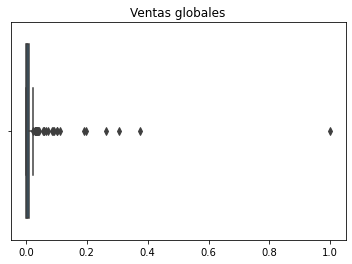

In [4]:
# Visualización de los datos
import seaborn as sns
import matplotlib.pyplot as plt

global_sales_arr = sales_ratings_df.select('Global_Sales_scaled').toPandas().to_numpy()
sns.boxplot(x=global_sales_arr).set_title('Ventas globales')

high_bound : Global_Sales_scaled    0.852115
Name: 0.999, dtype: float64


Text(0.5, 1.0, 'Ventas globales sin valores atípicos')

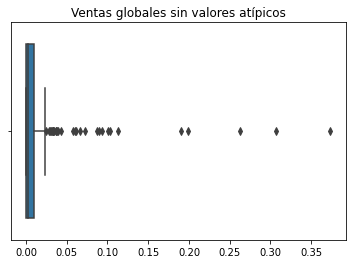

In [5]:
# Eliminando valores atípicos para norzalización de los datos
global_sales_pd = sales_ratings_df.select("Global_Sales_scaled").toPandas()

high_bound = global_sales_pd.quantile(0.999)
print('high_bound :', high_bound)

sales_ratings_df = sales_ratings_df.filter(col('Global_Sales_scaled') <= float(high_bound))
global_sales_np = sales_ratings_df.select("Global_Sales_scaled").toPandas().to_numpy()
sns.boxplot(x=global_sales_np).set_title('Ventas globales sin valores atípicos')

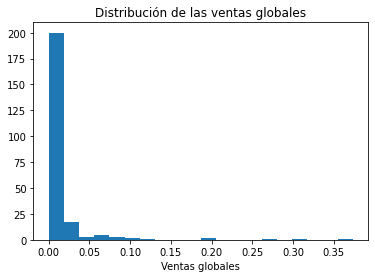

In [7]:
global_sales_pd = sales_ratings_df.select('Global_Sales_scaled').toPandas()
plt.hist(global_sales_pd, bins=20)
plt.xlabel('Ventas globales')
plt.title('Distribución de las ventas globales')
plt.show()

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['Global_Sales_scaled','alcohol_reference', 'animated_blood', 'blood', 
                'blood_and_gore', 'cartoon_violence', 'crude_humor', 
                'drug_reference', 'fantasy_violence', 'intense_violence', 
                'language', 'lyrics', 'mature_humor', 'mild_blood', 
                'mild_cartoon_violence', 'mild_fantasy_violence', 
                'mild_language', 'mild_lyrics', 'mild_suggestive_themes', 
                'mild_violence', 'no_descriptors', 'nudity', 'partial_nudity', 
                'sexual_content', 'sexual_themes', 'simulated_gambling', 
                'strong_janguage', 'strong_sexual_content', 
                'suggestive_themes', 'use_of_alcohol', 'use_of_drugs_and_alcohol', 'violence'],
    outputCol='Features')

vector_df = assembler.transform(sales_ratings_df)
vector_df = vector_df.select(['Features', 'Successful'])
vector_df.show()

+--------------------+----------+
|            Features|Successful|
+--------------------+----------+
|(32,[0,10,28],[4....|         0|
|(32,[0,3],[0.0040...|         0|
|      (32,[8],[1.0])|         0|
|(32,[0,5],[0.1004...|         1|
|(32,[0,20],[1.555...|         0|
|(32,[0,2,7,10],[4...|         0|
|(32,[0,3,23,25,26...|         0|
|(32,[0,3,11,28],[...|         0|
|(32,[0,16],[3.111...|         0|
|(32,[0,4,10,24],[...|         0|
|(32,[0,20],[1.555...|         0|
|(32,[0,14],[0.010...|         1|
|(32,[0,20],[0.021...|         1|
|(32,[0,8,19],[1.5...|         0|
|(32,[0,3,9,12,27,...|         0|
|(32,[0,4,23,24,26...|         0|
|(32,[0,4,26],[6.2...|         0|
|(32,[0,3,7,12,25]...|         0|
|(32,[0,7,11,13,25...|         0|
|(32,[0,3],[0.0010...|         0|
+--------------------+----------+
only showing top 20 rows



# Generando sets de entremamiento y de prueba

In [40]:
# creamos los sets de entrenamiento y prueba
train_df, test_df = vector_df.randomSplit([0.7, 0.3])
print('Cantidad de muestras para entrenamiento: ', train_df.count())
print('Cantidad de muestras para prueba: ', test_df.count())


Cantidad de muestras para entrenamiento:  159
Cantidad de muestras para prueba:  77


# Corriendo el modelo de regresión logística


In [83]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr = LogisticRegression(featuresCol = 'Features', labelCol = 'Successful', maxIter=10)
lrModel = lr.fit(train_df)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.025, 0.05]) \
    .addGrid(lr.maxIter, [1, 5, 10]) \
    .build()

evaluator_lr = BinaryClassificationEvaluator( labelCol='Successful')
# https://spark.apache.org/docs/latest/ml-tuning.html
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_lr,
                          numFolds=3)
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_df)

In [84]:
prediction_lr_train = cvModel.transform(train_df)
prediction_lr_test = cvModel.transform(test_df)
prediction_lr_test.select('Successful', 'prediction').where(prediction_lr_test.prediction != 0.0).show()
ct = prediction_lr_test.select('Successful', 'prediction').where(prediction_lr_test.prediction != 0.0).count()
print('Videojuegos cuyo exito proviene de su clasificación:', ct)

+----------+----------+
|Successful|prediction|
+----------+----------+
|         1|       1.0|
|         1|       1.0|
|         1|       1.0|
|         1|       1.0|
|         1|       1.0|
|         0|       1.0|
|         0|       1.0|
|         1|       1.0|
|         0|       1.0|
|         1|       1.0|
|         1|       1.0|
|         1|       1.0|
|         1|       1.0|
|         1|       1.0|
|         0|       1.0|
|         1|       1.0|
|         1|       1.0|
+----------+----------+

Videojuegos cuyo exito proviene de su clasificación: 17


In [69]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

vector_df.describe().show()

Coefficients: [857.6263878981135,-19.077029669102895,-10.01069741515797,-0.32180649749013196,-2.4696470498269383,-6.078897563364842,-1.998954109539533,12.155369853387704,-1.5422998099984295,6.340182926161411,-0.943004824633282,0.5411834251562154,-16.734627946423778,-10.987145057159166,-0.24145808304367622,-15.39210007020861,-12.708125284547892,-11.07432873922859,-12.717532612080683,-1.3525153213750785,-13.733679756582342,-4.59320019614947,5.8978015364603475,-12.23514476428709,-2.3922394253915495,0.6761178658212754,-3.4133649068645253,-8.895311017892563,-3.9692816719609443,-13.539564112095169,-11.83997993090592,-6.1992341561573845]
Intercept: -5.581160604487219
+-------+-------------------+
|summary|         Successful|
+-------+-------------------+
|  count|                236|
|   mean|               0.25|
| stddev|0.43393302748284274|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



# Corriendo el modelo de árboles de decisión

In [87]:
from pyspark.ml.classification import DecisionTreeClassifier

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="Successful", featuresCol="Features")
dt_model = dt.fit(train_df)
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.025, 0.05]) \
    .addGrid(lr.maxIter, [1, 5, 10]) \
    .build()

evaluator_dt = BinaryClassificationEvaluator( labelCol='Successful' )
# https://spark.apache.org/docs/latest/ml-tuning.html
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_dt,
                          numFolds=3)
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_df)


In [89]:
prediction_dt_train = cvModel.transform(train_df)
prediction_dt_test = cvModel.transform(test_df)
prediction_dt_test.select('Successful', 'prediction').show()
ct = prediction_dt_test.select('Successful', 'prediction').where(prediction_dt_test.prediction != 0.0).count()
print('Videojuegos cuyo exito proviene de su clasificación:', ct)

+----------+----------+
|Successful|prediction|
+----------+----------+
|         1|       1.0|
|         1|       1.0|
|         0|       0.0|
|         0|       0.0|
|         1|       1.0|
|         1|       1.0|
|         0|       0.0|
|         1|       1.0|
|         0|       0.0|
|         1|       1.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         1|       1.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 20 rows

Videojuegos cuyo exito proviene de su clasificación: 26


In [90]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(dt_model))

vector_df.describe().show()

Coefficients: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_34238519aed8, depth=3, numNodes=7, numClasses=2, numFeatures=32
+-------+-------------------+
|summary|         Successful|
+-------+-------------------+
|  count|                236|
|   mean|               0.25|
| stddev|0.43393302748284274|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [91]:
eval_lr = evaluator_lr.evaluate(prediction_lr_test)
aupr_lr = evaluator_lr.evaluate(prediction_lr_test, {evaluator_lr.metricName: "areaUnderPR"})
eval_td = evaluator_dt.evaluate(prediction_dt_test)
aupr_dt = evaluator_dt.evaluate(prediction_dt_test, {evaluator_dt.metricName: "areaUnderPR"})

print('Evaluación del modelo de regresión lineal:', eval_lr)
print('Área debejo de la curva precision-recall para regresión lineal:', aupr_lr)
print('Evaluación del modelo de árbol de decisión', eval_td)
print('Área debejo de la curva precision-recall para árbol de decisión:', aupr_dt)

Evaluación del modelo de regresión lineal: 0.8169230769230776
Área debejo de la curva precision-recall para regresión lineal: 0.7861276619985462
Evaluación del modelo de árbol de decisión 0.99
Área debejo de la curva precision-recall para árbol de decisión: 0.9600307692307692
